In [1]:
import pandas as pd
import numpy as np
import json, re, itertools, os
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import string, nltk
import collections
from nltk.corpus import stopwords
import time
import random, pickle
import ast
import copy
pd.options.mode.chained_assignment = None
from operator import itemgetter

In [5]:
# Some initilisations - please change the file_dir to your working directory to read the file
file_dir = '/home/danyzix/Dissertation/Data'

In [3]:
# pickling functions to save and load lists
def pickle_save(data, name):
    path = os.path.join(file_dir,'{}.pkl'.format(name))
    with open(path, "wb") as f:
        pickle.dump(data, f, protocol=-1)
        f.close()
def pickle_open(name):
    path = os.path.join(file_dir,'{}.pkl'.format(name))
    with open(path, "rb") as f:
        data = pickle.load(f)
        f.close()
    return data

Please note:

This notebook uses a retailer-manufacturer paired sequence data which is generated from the retail data I had prepared in the previous notebook and from the manufactuerer product database. From the retail data only three fields are used : Brand, Title, MPN to describe each product.
A similar data is prepared from the manufactuer database with the same fields as the retailer data.
The corresponding productIDs are added at the list.
The rb_pairs1 generated is a list of list with each item in a list as retailer sequence, manufacturer sequence, productID.

## Load retailer-brand pair sequence mapping


In [15]:
# load the retailer-manufactuerer mapped pairs with productID
rb_pairs1 = pickle_open('rb_pairs1')
len(rb_pairs1)

77451

In [14]:
# Lets look at the first item in the rb_pairs1 list. 
rb_pairs1[0]

['SAMSUNG SAMSUNG DV80M5010QX/EU 8 kg Heat Pump Tumble Dryer & AddWash WW80K5410UX 8 kg 1400 Spin Washing Machine Bundle WW80K5410UX',
 'Samsung DV5000 Heat Pump Tumble Dryer A++ 8kg DV80M5010QXEU',
 1172949]

## Data cleaning

A process of data-cleaning is implemented in the next step for each of the retail-brand pairs in the following order:

remove some punctuations -> remove English stop words -> remove duplicate words/tokens keeping the first occurence and removing the following.

In [16]:
# clean texts: lowercase, trim, de-dup.....
def normalise_text(t):
    # split into tokens by white space
    tokens = t.split()
    # replace a list punctuations with space from each token
    punctuations="""'!"#$%&\'()*,-/:;®™<=>?@[\\]^_`{|}~"""
    table = str.maketrans(punctuations,' '*len(punctuations))
    tokens = [w.translate(table) for w in tokens]
    tokens = [w.lower() for w in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # reduce multiple spaces to one  
    tokens = re.sub(' +', ' ', ' '.join(tokens)).split()
    # remove duplicate tokens preserving the order
    tokens = [i for n,i in enumerate(tokens) if i not in tokens[:n]]
    # join the string to a list
    tokens = ' '.join(tokens)
    return tokens

In [17]:
# cleaned the retail-brand text pairs is stored in a new list rb_pairs2
rb_pairs2=[]
for i in range(len(rb_pairs1)):
    retail_text = normalise_text(rb_pairs1[i][0])
    brand_text = normalise_text(rb_pairs1[i][1])
    rb_pairs2.append([retail_text, brand_text, rb_pairs1[i][2]])
len(rb_pairs2)

77451

## More data cleaning 

I investigate a bit more in the text sequences to have a better understanding of the data. The next few steps looks at the short length sequences and sequences with no numbers. 

One of the key item in this whole sequence matching task is the model numbers of the products and they usually have a number. So it will be helpful to understand how many of my sequence pairs do not have numbers.

In [18]:
# function to return texts with short texts
def get_short_texts(pairs, row_no, length):
    temp_list = []
    for i in range(len(pairs)):
        if len(pairs[i][row_no].split()) <= length:
            temp_list.append([i,pairs[i][row_no]])
    return temp_list

In [19]:
# lets look at 10 random rows with short retail texts <= 3 tokens
length = 3
for j in range(0,10):
    i = random.randint(0, len(get_short_texts(rb_pairs2, 0, length)))  # row_no = 0 is for retail text
    print(get_short_texts(rb_pairs2, 0, length)[i])

[38859, 'title']
[17778, 'panasonic tx49fx750b']
[21854, 'panasonic dmc tz100ebk']
[23694, 'hoover ho7d3120in']
[31031, 'title']
[66511, 'lg up970']
[65882, 'samsung rl220nctasr']
[34521, 'title']
[21997, 'lenses']
[67707, 'bosch sign email']


By looking at a few random rows of the retail sequence, we can see that some of them will be completely useless for this analysis as they have no information of the product at all.

In [20]:
# lets look at 10 random rows with short brand texts <= 3 tokens
length = 3
for j in range(0,10):
    i = random.randint(0, len(get_short_texts(rb_pairs2, 1, length)))  # row_no = 1 is for brand text
    print(get_short_texts(rb_pairs2, 1, length)[i])

[67140, 'samsung wa80e5lec wa80e5lecxtl']
[39648, 'kitchen aid 5ksm160psawh']
[15224, 'bosch wtwh7561gb']
[20209, 'hoover link dhl1482dr3r']
[62115, 'electrolux major ewf9025bqwa']
[7473, 'bosch cfa634gs1b']
[16021, 'bosch dem63ac00b']
[20157, 'hoover link hl41472d3w']
[11273, 'gorenje g641xuk 729810']
[59650, 'miele uk g4940sc']


Most of the brand sequences have a model number of the products which generally contains a number in the strings. Let's investigate further and look at texts which do not have any numbers.

In [21]:
# function to return texts with no numbers
def no_num_text(pairs, row_no):
    temp_list = []
    for i in range(len(pairs)):
        if not any(a.isdigit() for a in pairs[i][row_no]):
            temp_list.append([i,pairs[i][row_no]])
    return temp_list

In [22]:
# lets look at 10 random rows of retail texts with no numbers
for j in range(0,10):
    i = random.randint(0, len(no_num_text(rb_pairs2, 0)))    # row_num = 0 is for  text
    print(no_num_text(rb_pairs2, 0)[i])

[54657, 'blue buffalo homestyle recipe adult dog food']
[29926, 'fitbit alta large fitness tracker blue']
[55055, 'title']
[21293, 'bose omnijewel floor stands pair white']
[76544, 'dyson ball multifloor']
[63144, 'sign email']
[27884, 'title']
[70737, 'electrolux built in oven single electric']
[38967, 'title']
[63212, '']


In [23]:
# lets look at 10 random rows of brand texts with no numbers
for j in range(0,10):
    i = random.randint(0, len(no_num_text(rb_pairs2, 1)))    # row_num = 1 is for brand text
    print(no_num_text(rb_pairs2, 1)[i])

[69316, 'sony high power home audio system bluetooth technology']
[4277, 'apple river page macbook']
[35029, 'jbl endurance jump black jblendurjumpblk jumpblkhpcc']
[22056, 'beko frost free combi fridge freezer water dispenser']
[36017, 'jbl endurance run yellow jblendurrunbnl']
[7785, 'amazon new kindle paperwhite allnewkindlepaperwhite']
[7779, 'amazon kindle e reader amazonkindle']
[56597, 'microsoft mixed reality generic countriestoad']
[15120, 'sonos playbar wireless sound bar']
[3809, 'hyperx cloud alpha hxhscardem']


By looking at some random sequences of both the retail and brand texts, we can see that we can make the data cleaner by just removing all pairs which do not any number in each of the sequence pairs.

I'll create a new list rb_pairs3 which will store the rest of retail-brand pairs after cleaning.

In [24]:
# function to remove pairs which do not have numbers in the retail and brand texts
def remove_no_num_pairs(pairs):
    bad_pairs = []
    good_pairs = []
    r_rows = no_num_text(pairs, 0)    # get retail text rows with no numbers
    b_rows = no_num_text(pairs, 1)    # get brand text rows with no numbers
    for i in range(len(pairs)):
        if (pairs[i][0] in [a[1] for a in r_rows]) or (pairs[i][1] in [a[1] for a in b_rows]):
            bad_pairs.append(pairs[i])
        else:
            good_pairs.append(pairs[i])
    return bad_pairs, good_pairs

In [25]:
# generate two separate lists for further analysis
# rb_pairs3 is the clean list after removing the no number text pairs
# bad_pairs is the cleaned list 
bad_pairs, rb_pairs3 = remove_no_num_pairs(rb_pairs2)

print('# of pairs before cleaning : {} \n# of pairs after cleaning : {}'.format(len(rb_pairs2),len(rb_pairs3)))

# of pairs before cleaning : 77451 
# of pairs after cleaning : 67457


In [26]:
# bad/good pair ratio
len(bad_pairs), len(rb_pairs3) , len(bad_pairs)/(len(bad_pairs)+len(rb_pairs3))*100   

(9994, 67457, 12.903642302875367)

I'm losing 13% of my data. Not sure if that's okay but it'll take more time to clean more than this so I'll continue with the analysis as it is.

# Brand sequence - prodict_id mapping

The next step is to form a unique brand-sequence to product_id (one-to-one) mapping. This mapping is necessary for the evaluation process when I'll measuring the accuracy of the model. 

For now lets just go ahead a generate this mapping and we'll understand the reason for this later on.

In [27]:
# function to get unique texts and update a Counter from a list
def get_unique_texts(data, row):
    temp_text = []
    for i in range(len(data)):
        temp_text.append(data[i][row])
    counter = collections.Counter(temp_text)               # add a counter to count the frequency of texts in the brand texts
    unique_text = list(set(temp_text))                     # form a set of unique texts for the data
    return counter, unique_text         

As we have now have 67,457 retail-brand pairs, but some of the retail sequences will be mapped to the same brand sequence as multiple retailer urls can have some product. 

In the next few steps, I'll be looking at how many unique brand-sequences are mapped exist in the whole retail-brand pairs. I will then create a list of unique brand-sequence to product_id map.

In [28]:
# get the unique brand texts from the retail-brand pairs
b_counter, unique_brand_text = get_unique_texts(rb_pairs3, 1)
# lets look at some of the most common brand text mapped to retail texts
b_counter.most_common(5)

[('hoover vision 34001950 34002041 hfze54w uighhghjajsajjmnsabhaj 34002042 hfle45w hvbf5182awk 37000416 34001951 34002031 34002028 34002025 34900370 34002029 34002030 37000415 34002027 hsc574w hfoe54w hvbf5182wwk hsc574b hbrup160k',
  85),
 ('amd components logo program am4 300 chipset am4300', 62),
 ('fitbit charge 3 fb410gmwteu fb409gmbkeu fb410rglveu fb409rggyeu', 48),
 ('bose quietcomfort 35 wireless headphones ii black 7895640010', 40),
 ('microsoft wireless mobile mouse 1850 light u7z00033 u7z00032 u7z00035 u7z00043 u7z00044 u7z00005 u7z00022 u7z00015 u7z00031 u7z00024 u7z00013 u7z00065 amer u7z00012 u7z00002 u7z00004 u7z00060 u7z00016 u7z00011 u7z00036 u7z00001 u7z00003 u7z00048 u7z00038 u7z00041 u7z00057 u7z00055 u7z00062 u7z00008remove u7z00064 u7z00038removed u7z00025 u7z00066 u7z00063 u7z00021 orchid u7z00034 u7z00056 u7z00018 u7z00028 u7z00059 u7z00058 u7z00008 u7z00045 u7z00006 u7z00042 u7z00014',
  33)]

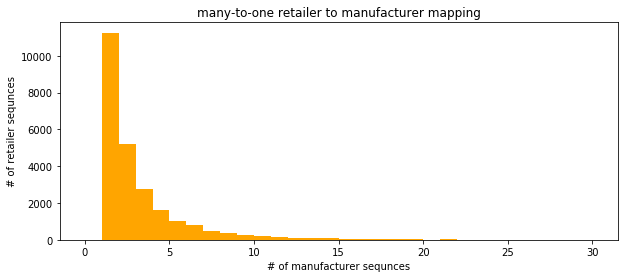

In [29]:
# a histogarm to see the many-to-one relationship
plt.figure(figsize=(10,4))
plt.hist([n for a,n in b_counter.items()], bins=30,range=[0, 30], color='orange')
plt.title('many-to-one retailer to manufacturer mapping')
plt.ylabel('# of retailer sequnces')
plt.xlabel('# of manufacturer sequnces')
plt.show()

We can already see there could be many brand-sequences mapped to multiple retailer-sequences.

Next will append the corresponding product_ids found for each or the brand-sequence.

In [30]:
# add the product_id to each unique brand text
brand_text_product_mapping = []                       
for a in unique_brand_text:
    products = []
    for i in range(len(rb_pairs3)):
        if a == rb_pairs3[i][1]:
            products.append(rb_pairs3[i][2])                # extract all product_ids which map to a certain brand text
    products = list(set(products))                  # keep only the unique product_ids
    brand_text_product_mapping.append([a, products])    # create a list of list with brand text and its corresponding product_ids

In [31]:
print('number of unique brand-sequences: {}'.format(len(unique_brand_text)))

number of unique brand-sequences: 24645


I also discovered that there are some brand-sequences which have multiple product_ids. This needs to be normalised as it'll cause an issue in the evaluation. 

I'll assign the first product in the order to the corresponding brand-sequence. The same product_id will be updated in the retail-brand pairs as well.

In [32]:
# there are some brand texts which have more than one product_id, let's look at them
multi_product_texts = []
for i in range(len(brand_text_product_mapping)):
    if len(brand_text_product_mapping[i][1])>1:
        multi_product_texts.append(brand_text_product_mapping[i])
multi_product_texts

[['tp link archer c7', [958697, 889676]],
 ['lg electronics tone+ wireless stereo headset hbs730', [867184, 810861]],
 ['lg electronics musicflow hs8 curved wireless multi room speaker las855m',
  [946004, 1169453]],
 ['logitech wireless mini mouse m187', [820954, 820959]],
 ['flixmedia washer dryer combo 8.5kg 5kg',
  [1407152, 1551109, 1452318, 1424855]],
 ['logitech m337', [945790, 945791]],
 ['bosch tda5070gb', [1578067, 1469940]],
 ['sony α6400 e mount camera aps c sensor black ilce6400lbap2',
  [1555538, 1556943]],
 ['sony fe 24 105mm f4 g oss lens sel24105gsyx', [1296588, 1300469]],
 ['lg electronics tone protm bluetooth stereo headset hbs 750 hbs750',
  [1169530, 894349]],
 ['logitech m171', [1002720, 1002719]],
 ['alcatel tcl 3c alcatel3c', [1322448, 1421819]]]

In [33]:
# add the product_id to each unique brand text
unique_brand_text_product_mapping = []                       
for a in unique_brand_text:
    products = []
    for i in range(len(rb_pairs3)):
        if a == rb_pairs3[i][1]:
            products.append(rb_pairs3[i][2])                # extract all product_ids which map to a certain brand text
    products = list(set(products))                          # keep only the unique product_ids
    unique_brand_text_product_mapping.append([a, products[0]])   # append the first product_id if there are multilpe

In [34]:
# let's verify if the product_ids have been updated
[a for a in unique_brand_text_product_mapping  if a[0]== 'logitech m171']

[['logitech m171', 1002720]]

In [35]:
# now we'll update all new product-ids in rb_pairs3 to keep uniformity in the evaluation process
for a in multi_product_texts:
    for b in rb_pairs3:
        if a[0] == b[1]:
            b[2] = a[1][0]

In [36]:
# Lets look at the cleaned rb_pairs3 data
for i in range(0,3):
    j = random.randint(0,len(rb_pairs3))   
    print('retailer sequence :{}'.format(rb_pairs3[j][0]))
    print('manufacturer sequence :{}'.format(rb_pairs3[j][1]))
    print('product_ID : {}'.format(rb_pairs3[j][2]))
    print('------------------------------------------')

retailer sequence :lego duplo 10871 airport
manufacturer sequence :lego airport b00t7sayso lego10871
product_ID : 1312402
------------------------------------------
retailer sequence :beats dre solo3 bluetooth on ear headphones mic control matte gold mr3y2ll a
manufacturer sequence :beats dr. dre solo³ wireless on ear headphones matt gold mr3y2paa mr3y2lla mr3y2zma
product_ID : 1296970
------------------------------------------
retailer sequence :panasonic tx55fz952b 55 ultra hd 4k pro hdr oled television
manufacturer sequence :panasonic 55 ultra hd 4k pro hdr oled television tx 55fz952b tx55fz952b
product_ID : 1315701
------------------------------------------


In [37]:
# Lets look at the manufacturer sequence-productID mapping 
for i in range(0,3):
    j = random.randint(0,len(unique_brand_text_product_mapping))   
    print('manufacturer_sequence :{}'.format(unique_brand_text_product_mapping[j][0]))
    print('product_id : {}'.format(unique_brand_text_product_mapping[j][1]))
    print('------------------------------------------')

manufacturer_sequence :fisher paykel freestanding dual fuel cooker 90cm or90scg6w1
product_id : 1533825
------------------------------------------
manufacturer_sequence :hp 940xl cyan officejet ink cartridge c4907an c4907an140
product_id : 621684
------------------------------------------
manufacturer_sequence :epson ink cartridge xxl cyan 3.4k c13t70124010
product_id : 609784
------------------------------------------


Now the data is clean to train the model so lets save it.

In [89]:
# save the files
pickle_save(unique_brand_text_product_mapping, 'unique_brand_text_product_mapping')
pickle_save(rb_pairs3,'rb_pairs3')